# Applying Advanced Reinforcement Learning to No Limit Hold'em

## The Environment
We use the RLCard environment, which can be found [here](https://github.com/datamllab/rlcard/tree/master/rlcard/games/nolimitholdem).

## Random Agent

In [1]:
import time
import rlcard
from random_agent import RandomAgent
from utils import set_global_seed

# Make environment
env = rlcard.make('no-limit-holdem', config={'seed': 0})
episode_num = 2

# Set a global seed
set_global_seed(0)

# Set up agents
tic = time.perf_counter()
agent = RandomAgent(action_num=env.action_num)
env.set_agents([agent, agent])

for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=False)

    # Print out the trajectories
    print('\nEpisode {}'.format(episode))
    for ts in trajectories[0]:
        print('State: {}, Action: {}, Reward: {}, Next State: {}, Done: {}'.format(ts[0], ts[1], ts[2], ts[3], ts[4]))
toc = time.perf_counter()
print(f"Random Agent takes {toc - tic:0.4f} seconds to run")


Episode 0
State: {'legal_actions': [0, 2, 3, 4, 5], 'obs': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 2.])}, Action: 5, Reward: 2.0, Next State: {'legal_actions': [0, 1, 5], 'obs': array([  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   1.,   0.,   0.,   0., 100., 100.])}, Done: True

Episode 1
Random Agent takes 0.0039 seconds to run


## Deep-Q Agent

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.

----------------------------------------
  timestep     |  2
  reward       |  1.948
----------------------------------------

----------------------------------------
  timestep     |  289
  reward       |  2.287
----------------------------------------

----------------------

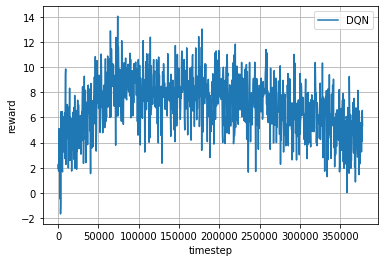

In [2]:
import tensorflow as tf
import os
import time

import rlcard
from dqn_agent import DQNAgent
from random_agent import RandomAgent
from utils import set_global_seed, tournament
from logger import Logger

# Make environment
env = rlcard.make('no-limit-holdem', config={'seed': 0})
eval_env = rlcard.make('no-limit-holdem', config={'seed': 0})

# Set the iterations numbers and how frequently we evaluate the performance
evaluate_every = 100
evaluate_num = 1000
episode_num = 100000

# The intial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

# The paths for saving the logs and learning curves
log_dir = './experiments/nolimit_holdem_dqn_result/'

# Set a global seed
set_global_seed(0)
tic = time.perf_counter()

with tf.Session() as sess:

    # Initialise a global step
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Set up the agents
    agent = DQNAgent(sess,
                     scope='dqn',
                     action_num=env.action_num,
                     replay_memory_init_size=memory_init_size,
                     train_every=train_every,
                     state_shape=env.state_shape,
                     mlp_layers=[512, 512])
    random_agent = RandomAgent(action_num=eval_env.action_num)
    env.set_agents([agent, random_agent])
    eval_env.set_agents([agent, random_agent])

    # Initialise global variables
    sess.run(tf.global_variables_initializer())

    # Init a Logger to plot the learning curve
    logger = Logger(log_dir)

    for episode in range(episode_num):

        # Generate data from the environment
        trajectories, _ = env.run(is_training=True)

        # Feed transitions into agent memory, and train the agent
        for ts in trajectories[0]:
            agent.feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])
    
    # Close files in the logger
    logger.close_files()
    
    toc = time.perf_counter()
    print(f"\nDQN Agent takes {toc - tic:0.4f} seconds to run")

    # Plot the learning curve
    logger.plot('DQN')
    
    # Save model
    save_dir = 'models/nolimit_holdem_dqn'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(save_dir, 'model'))

## Neural Fictious Self-Play Agent

In [1]:
import tensorflow as tf
import os
import time

import rlcard
from nfsp_agent import NFSPAgent
from random_agent import RandomAgent
from utils import set_global_seed, tournament
from logger import Logger

# Make environment
env = rlcard.make('no-limit-holdem', config={'seed': 0})
eval_env = rlcard.make('no-limit-holdem', config={'seed': 0})

# Set the iterations numbers and how frequently we evaluate the performance
evaluate_every = 100
evaluate_num = 1000
episode_num = 100000

# The intial memory size
memory_init_size = 1000

# Train the agent every X steps
train_every = 1

# The paths for saving the logs and learning curves
log_dir = './experiments/nolimit_holdem_nfsp_result/'

# Set a global seed
set_global_seed(0)
tic = time.perf_counter()

with tf.Session() as sess:

    # Initialise a global step
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Set up the agents
    agents = []
    for i in range(env.player_num):
        agent = NFSPAgent(sess,
                          scope='nfsp' + str(i),
                          action_num=env.action_num,
                          state_shape=env.state_shape,
                          hidden_layers_sizes=[512,512],
                          anticipatory_param=0.1,
                          min_buffer_size_to_learn=memory_init_size,
                          q_replay_memory_init_size=memory_init_size,
                          train_every = train_every,
                          q_train_every=train_every,
                          q_mlp_layers=[512,512])
        agents.append(agent)
    random_agent = RandomAgent(action_num=eval_env.action_num)

    env.set_agents(agents)
    eval_env.set_agents([agents[0], random_agent])

    # Initialise global variables
    sess.run(tf.global_variables_initializer())

    # Init a Logger to plot the learning curve
    logger = Logger(log_dir)

    for episode in range(episode_num):

        # First sample a policy for the episode
        for agent in agents:
            agent.sample_episode_policy()

        # Generate data from the environment
        trajectories, _ = env.run(is_training=True)

        # Feed transitions into agent memory, and train the agent
        for i in range(env.player_num):
            for ts in trajectories[i]:
                agents[i].feed(ts)

        # Evaluate the performance. Play with random agents.
        if episode % evaluate_every == 0:
            logger.log_performance(env.timestep, tournament(eval_env, evaluate_num)[0])

    # Close files in the logger
    logger.close_files()
    
    toc = time.perf_counter()
    print(f"\nNFSP Agent takes {toc - tic:0.4f} seconds to run")

    # Plot the learning curve
    logger.plot('NFSP')
    
    # Save model
    save_dir = 'models/nolimit_holdem_nfsp'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(save_dir, 'model'))

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.


----------------------------------------
  timestep     |  5
  reward       |  0.017
----------------------------------------

----------------------------------------
  timestep     |  293
  reward       |  1.522
----------------------------------------

---------------------

## Performance Comparison

In [8]:
import pandas as pd
dqn_df = pd.read_csv("/Users/gordontveito-duncan/Google Drive/Deep Learning CW/Poker Code/experiments/nolimit_holdem_dqn_result/performance.csv")
nfsp_df = pd.read_csv("/Users/gordontveito-duncan/Google Drive/Deep Learning CW/Poker Code/experiments/nolimit_holdem_nfsp_result/performance.csv")

In [9]:
dqn_df.tail()

,timestep,reward
995,376630,3.259
996,376948,6.385
997,377260,4.109
998,377606,6.568
999,377910,5.329


In [10]:
nfsp_df.tail()

,timestep,reward
995,447038,3.492
996,447772,2.020
997,448361,1.142
998,448926,4.687
999,449613,2.671


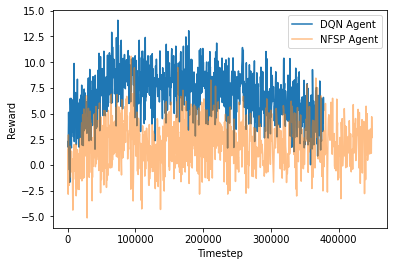

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot("timestep", "reward", data=dqn_df, label="DQN Agent")
plt.plot("timestep", "reward", data=nfsp_df, label="NFSP Agent", alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.legend()
plt.show()

In [12]:
fig.savefig("Perf_comp.png")

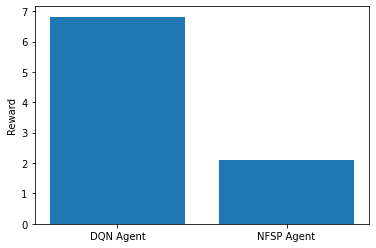

DQN Agent Average Reward: 6.82, NFSP Agent Average Reward: 2.10
DQN Agent Standard Deviation of Reward: 2.30, NFSP Agent Standard Deviation of Reward: 2.23


In [13]:
dqn_avg = dqn_df['reward'].mean()
dqn_sd = dqn_df['reward'].std()
nfsp_avg = nfsp_df['reward'].mean()
nfsp_sd = nfsp_df['reward'].std()
fig = plt.figure()
plt.bar(['DQN Agent', 'NFSP Agent'],[dqn_avg,nfsp_avg])
plt.ylabel("Reward")
plt.show()
fig.savefig("Reward_comp.png")

print("DQN Agent Average Reward: {:0.2f}, NFSP Agent Average Reward: {:0.2f}".format(dqn_avg,nfsp_avg))
print("DQN Agent Standard Deviation of Reward: {:0.2f}, NFSP Agent Standard Deviation of Reward: {:0.2f}".format(dqn_sd,nfsp_sd))

**Comment:**
The DQN Agent has a higher average payout and standard deviation compared to the NFSP Agent.

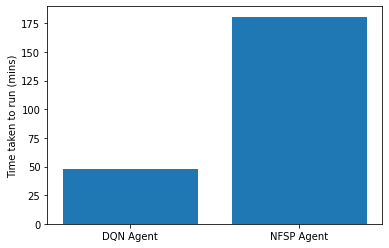

DQN Agent Time: 47.44 minutes, NFSP Agent Time: 180.82 minutes


In [14]:
dqn_time = 2846.6586/60
nfsp_time = 10849.1703/60
fig = plt.figure()
plt.bar(['DQN Agent', 'NFSP Agent'],[dqn_time,nfsp_time])
plt.ylabel("Time taken to run (mins)")
plt.show()
fig.savefig("Time_comp.png")

print("DQN Agent Time: {:0.2f} minutes, NFSP Agent Time: {:0.2f} minutes".format(dqn_time,nfsp_time))